<a href="https://colab.research.google.com/github/CarlaSa/Deep_Vision_Project/blob/master/First_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

     \ 307kB 3.8MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=b835690afa2f93765db58497e53166ff0d1c67d3a3b9d9f31e9db9268a9d4634
  Stored in directory: /tmp/pip-ephem-wheel-cache-r95360ee/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [6]:
BETA1 = 0.5
NUM_EPOCHS = 100
NUM_CLASSES = 10
BATCH_SIZE = 100
NOISE_SIZE = 100 

SMOOTHNESS = 0.1

In [7]:
# load data
dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.ToTensor())
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True)

dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms.ToTensor())
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = BATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print(dataset_train)
print(dataset_test)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


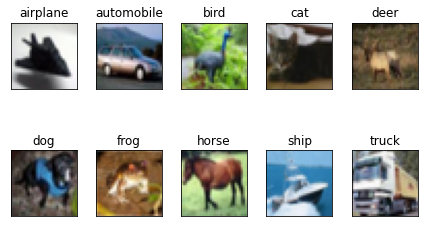

In [9]:
# work with data
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

for i in range(10):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    for j in range(50000):
        if dataset_train[j][1] == i:
            idx = j
            break
    img = F.to_pil_image(dataset_train[idx][0])
    ax.set_title(class_names[i])
    #print(img)
    plt.imshow(img)
plt.tight_layout()

In [10]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.dense = torch.nn.Sequential(
            torch.nn.Linear(in_features = NOISE_SIZE + 10 , out_features= 512 *2*2),
            torch.nn.BatchNorm1d(2048, momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        
        self.ReLU = torch.nn.ReLU()
        self.conv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 512 , out_channels= 256, kernel_size=5, stride=2, padding=2, output_padding= 1),
            torch.nn.BatchNorm2d(256,momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 256, out_channels= 128, kernel_size=5, stride=2, padding=2, output_padding= 1),
            torch.nn.BatchNorm2d(128, momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 128, out_channels= 64, kernel_size=5, stride=2, padding=2, output_padding= 1),
            torch.nn.BatchNorm2d(64, momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 64, out_channels= 3, kernel_size=5, stride=2, padding=2, output_padding= 1),
        )

    def forward(self, noise, labels):
        """
        noise has shape (BATCHSIZE, 1)
        labels has shape (BATCHSIZE,)
        """
        
        labels = torch.nn.functional.one_hot(labels, num_classes = 10) #shape (BATCH_SIZE, 10)
        temp = torch.cat((noise, labels.float()), 1) #shape (BATCH_SIZE, NOISE_SIZE)
        temp = self.dense(temp) #shape (BATCH_SIZE, 2048)
        #temp = self.ReLU(temp)
        
        temp = torch.reshape(temp, (-1, 512,2,2))  # shape (BATCH_SIZE, 512,2,2)
        temp = self.conv1(temp) # shape (BATCH_SIZE, 256, 4, 4)
        temp = self.conv2(temp) # shape (BATCH_SIZE, 128, 8, 8)
        temp = self.conv3(temp) # shape (BATCH_SIZE, 64, 16, 16)
        temp = self.conv4(temp) # shape (BATCH_SIZE, 3, 32, 32)
        
        return torch.tanh(temp)
        
    
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # TO DO : padding should be same
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=5, stride= 2, padding=2),
            torch.nn.BatchNorm2d(64,momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 64, out_channels= 128, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(128,momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 128, out_channels= 256, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(256, momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 256, out_channels= 512, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(512,momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        
        self.flatten = torch.nn.Flatten()
        
        self.fully_connected = torch.nn.Sequential(
            torch.nn.Linear(2058, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1),
            torch.nn.Sigmoid()
        )
        
        
    def forward(self, images, labels):
        
        temp = self.conv1(images)
        temp = self.conv2(temp)
        temp = self.conv3(temp)
        temp = self.conv4(temp)
        
        temp = self.flatten(temp)
        
        
        # bring label in right form and add as dimention
        temp_labels = torch.nn.functional.one_hot(labels, num_classes = 10)
        temp = torch.cat([temp, temp_labels.float()], 1)
        
        temp = self.fully_connected(temp)
        return temp
        

In [11]:
#opt

real_label = 1
false_label = 0

Gen = Generator()
Disc = Discriminator()

opt_gen = torch.optim.Adam(Gen.parameters(), lr = 0.0002, betas = (BETA1, 0.999))
opt_disc = torch.optim.Adam(Disc.parameters(), lr = 0.0002, betas = (BETA1, 0.999))
loss = torch.nn.BCELoss()

In [12]:
Gen = Gen.cuda()
Disc = Disc.cuda()

epoch: 0


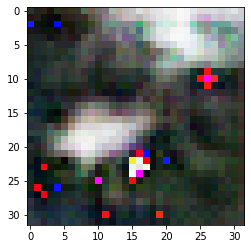

label: cat
D-Loss is 0.29464519023895264 and G-Loss is 3.9348700046539307


epoch: 1
D-Loss is 0.24552768468856812 and G-Loss is 5.164946556091309


epoch: 2
D-Loss is 0.22656935453414917 and G-Loss is 4.977277755737305


epoch: 3
D-Loss is 0.2505824565887451 and G-Loss is 6.074894428253174


epoch: 4
D-Loss is 0.2592957019805908 and G-Loss is 5.796308994293213


epoch: 5


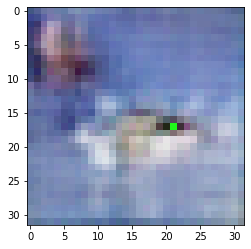

label: dog
D-Loss is 0.22822175920009613 and G-Loss is 7.151330471038818


epoch: 6
D-Loss is 0.2688903510570526 and G-Loss is 8.76352310180664


epoch: 7
D-Loss is 0.26127105951309204 and G-Loss is 4.925983905792236


epoch: 8
D-Loss is 0.2566830515861511 and G-Loss is 6.212764263153076


epoch: 9
D-Loss is 0.1768798530101776 and G-Loss is 6.938668251037598


epoch: 10


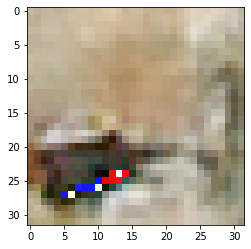

label: automobile
D-Loss is 0.21967796981334686 and G-Loss is 7.773561954498291


epoch: 11
D-Loss is 0.18472595512866974 and G-Loss is 7.471596717834473


epoch: 12
D-Loss is 0.1796446144580841 and G-Loss is 10.38354206085205


epoch: 13
D-Loss is 0.3921065032482147 and G-Loss is 7.040070533752441


epoch: 14
D-Loss is 0.23400579392910004 and G-Loss is 7.486847877502441


epoch: 15


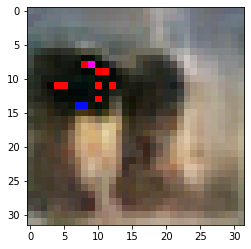

label: truck
D-Loss is 0.2823278307914734 and G-Loss is 8.46827220916748


epoch: 16
D-Loss is 0.22272340953350067 and G-Loss is 6.719490051269531


epoch: 17
D-Loss is 0.28144514560699463 and G-Loss is 1.7113512754440308


epoch: 18
D-Loss is 0.290411114692688 and G-Loss is 9.244938850402832


epoch: 19
D-Loss is 0.2139115035533905 and G-Loss is 6.573718070983887


epoch: 20


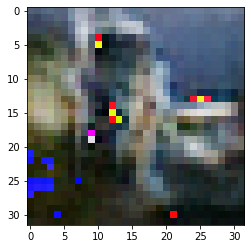

label: bird
D-Loss is 0.2334505319595337 and G-Loss is 12.408583641052246


epoch: 21
D-Loss is 0.26147815585136414 and G-Loss is 9.935620307922363


epoch: 22
D-Loss is 0.20361372828483582 and G-Loss is 6.891386032104492


epoch: 23
D-Loss is 0.1955767273902893 and G-Loss is 7.30447244644165


epoch: 24
D-Loss is 0.28842830657958984 and G-Loss is 18.12293243408203


epoch: 25


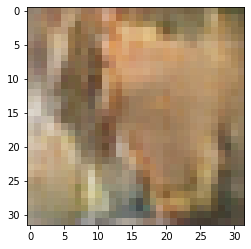

label: airplane
D-Loss is 0.22944554686546326 and G-Loss is 9.480544090270996


epoch: 26
D-Loss is 0.21313245594501495 and G-Loss is 7.954041957855225


epoch: 27
D-Loss is 0.18001846969127655 and G-Loss is 7.108244895935059


epoch: 28
D-Loss is 0.17024195194244385 and G-Loss is 11.966580390930176


epoch: 29
D-Loss is 0.4291174113750458 and G-Loss is 0.3334161937236786


epoch: 30


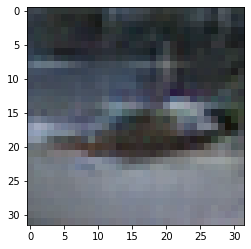

label: ship
D-Loss is 0.1866416186094284 and G-Loss is 7.7827982902526855


epoch: 31
D-Loss is 0.45269227027893066 and G-Loss is 20.844648361206055


epoch: 32
D-Loss is 0.2816561460494995 and G-Loss is 4.437018871307373


epoch: 33
D-Loss is 0.18991272151470184 and G-Loss is 9.632402420043945


epoch: 34
D-Loss is 0.1792512983083725 and G-Loss is 14.858243942260742


epoch: 35


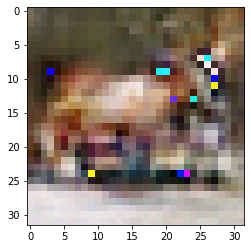

label: automobile
D-Loss is 0.17838747799396515 and G-Loss is 11.274645805358887


epoch: 36
D-Loss is 0.21155914664268494 and G-Loss is 7.859190464019775


epoch: 37
D-Loss is 0.17377886176109314 and G-Loss is 12.849848747253418


epoch: 38
D-Loss is 0.26363158226013184 and G-Loss is 3.824188470840454


epoch: 39
D-Loss is 0.3307911157608032 and G-Loss is 16.1785945892334


epoch: 40


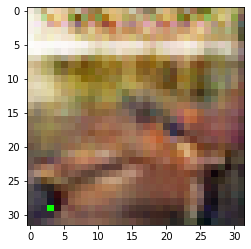

label: airplane
D-Loss is 0.19670969247817993 and G-Loss is 7.135040283203125


epoch: 41
D-Loss is 0.5461368560791016 and G-Loss is 12.241320610046387


epoch: 42
D-Loss is 0.19184350967407227 and G-Loss is 13.21973991394043


epoch: 43
D-Loss is 0.21858391165733337 and G-Loss is 4.36160945892334


epoch: 44
D-Loss is 0.1728735864162445 and G-Loss is 9.09478759765625


epoch: 45


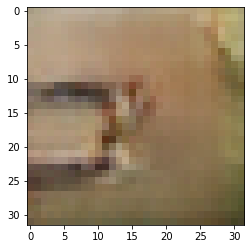

label: automobile
D-Loss is 0.16762608289718628 and G-Loss is 13.744074821472168


epoch: 46
D-Loss is 0.18151625990867615 and G-Loss is 10.161832809448242


epoch: 47
D-Loss is 0.2027132511138916 and G-Loss is 9.773984909057617


epoch: 48
D-Loss is 0.18363042175769806 and G-Loss is 9.868928909301758


epoch: 49
D-Loss is 0.18186800181865692 and G-Loss is 12.24935531616211


epoch: 50


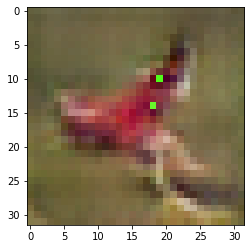

label: frog
D-Loss is 0.22576123476028442 and G-Loss is 15.027926445007324


epoch: 51
D-Loss is 0.2104470133781433 and G-Loss is 17.080148696899414


epoch: 52
D-Loss is 0.26351800560951233 and G-Loss is 3.8376541137695312


epoch: 53
D-Loss is 0.2093859761953354 and G-Loss is 5.430333137512207


epoch: 54
D-Loss is 0.19340349733829498 and G-Loss is 12.304680824279785


epoch: 55


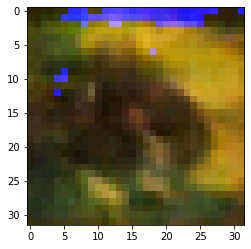

label: ship
D-Loss is 0.20982205867767334 and G-Loss is 10.17288589477539


epoch: 56
D-Loss is 0.20462143421173096 and G-Loss is 4.2634196281433105


epoch: 57
D-Loss is 0.17304669320583344 and G-Loss is 10.730228424072266


epoch: 58
D-Loss is 0.17920073866844177 and G-Loss is 11.49850845336914


epoch: 59
D-Loss is 0.18257422745227814 and G-Loss is 12.238595962524414


epoch: 60


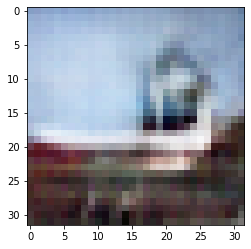

label: truck
D-Loss is 0.5488947629928589 and G-Loss is 28.83836555480957


epoch: 61
D-Loss is 0.17207682132720947 and G-Loss is 12.94417953491211


epoch: 62
D-Loss is 0.17783185839653015 and G-Loss is 15.000422477722168


epoch: 63
D-Loss is 0.16925327479839325 and G-Loss is 17.384735107421875


epoch: 64
D-Loss is 0.1938590705394745 and G-Loss is 9.40580940246582


epoch: 65


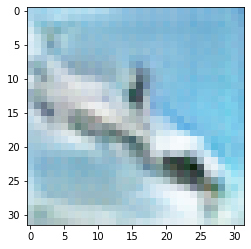

label: automobile
D-Loss is 0.2601151466369629 and G-Loss is 9.254480361938477


epoch: 66
D-Loss is 0.18523146212100983 and G-Loss is 9.651055335998535


epoch: 67
D-Loss is 0.1875729262828827 and G-Loss is 5.627770900726318


epoch: 68
D-Loss is 0.17906305193901062 and G-Loss is 5.200359344482422


epoch: 69
D-Loss is 0.1711544543504715 and G-Loss is 9.180400848388672


epoch: 70


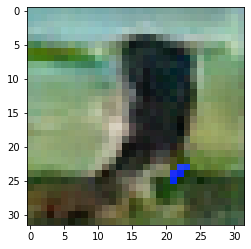

label: ship
D-Loss is 0.20755362510681152 and G-Loss is 14.386958122253418


epoch: 71
D-Loss is 0.1956941783428192 and G-Loss is 8.532444953918457


epoch: 72
D-Loss is 0.22411692142486572 and G-Loss is 6.101687908172607


epoch: 73
D-Loss is 0.18038493394851685 and G-Loss is 15.263354301452637


epoch: 74
D-Loss is 0.17543156445026398 and G-Loss is 8.634791374206543


epoch: 75


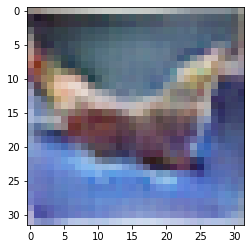

label: truck
D-Loss is 0.19547785818576813 and G-Loss is 9.515422821044922


epoch: 76
D-Loss is 0.21507376432418823 and G-Loss is 4.702411651611328


epoch: 77
D-Loss is 0.16910043358802795 and G-Loss is 25.60038948059082


epoch: 78
D-Loss is 0.3189328610897064 and G-Loss is 20.920473098754883


epoch: 79
D-Loss is 0.18637824058532715 and G-Loss is 21.73163604736328


epoch: 80


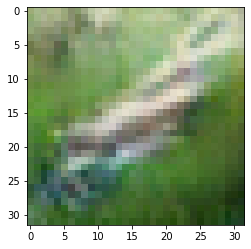

label: frog
D-Loss is 0.17225144803524017 and G-Loss is 17.464191436767578


epoch: 81
D-Loss is 0.17759616672992706 and G-Loss is 22.43857765197754


KeyboardInterrupt: ignored

In [18]:
# training
i = 0
for epoch in tqdm(range(NUM_EPOCHS)):
    for image, category in tqdm(data_loader_train):
        image = image.cuda()
        category = category.cuda()

        # train Discriminator--------------------------------------
        opt_disc.zero_grad()
        
        # train with true pictures -----
        output = Disc(image, category)
        
        label = torch.full(size = (BATCH_SIZE,1), fill_value = real_label * (1- SMOOTHNESS))
        label = label.cuda()
        disc_loss_real = loss(output, label)
        #disc_loss_real.backward()
        
        #train with generated pictures -----
        
        #generate input from Generator
        # noise is taken from N(0,1) distribution
        noise = torch.randn(size = (BATCH_SIZE, NOISE_SIZE))
        noise = noise.cuda()
        gen_categories = torch.randint(low = 0, high = 10, size = (BATCH_SIZE,))
        gen_categories = gen_categories.cuda()
        inp = Gen(noise, gen_categories)
        
        output = Disc(inp.detach(), gen_categories)
        
        label = torch.full(size = (BATCH_SIZE, 1), fill_value = false_label)
        label = label.cuda()
        disc_loss_false = loss(output, label)
        #disc_loss_false.backward()
        
        disc_loss = 0.5 * (disc_loss_false + disc_loss_real)
        disc_loss.backward()
        opt_disc.step()
        
        # train Generator--------------------------------------
        opt_gen.zero_grad()
        #we don't calculate noise and gen_categories twice, inp stays the same
        # we updated Disc so we calculate it again
        output = Disc(inp, category)
        
        label = torch.full(size = (BATCH_SIZE, 1), fill_value = real_label)
        label = label.cuda()
        # we calculate the difference to the real label
        
        batch_loss = loss(output, label)
        batch_loss.backward()
        opt_gen.step()
        
    print("epoch: " + str(epoch))
    if epoch %5 == 0:
        inp = inp.cpu()
        Img = F.to_pil_image(inp[0])
        plt.imshow(Img)
        plt.show()
        print("label: " + class_names[gen_categories[0].item()])
    print("D-Loss is " + str(disc_loss.item()) + " and G-Loss is " + str(batch_loss.item()))
        

In [20]:
# save weights

from google.colab import drive
drive.mount("/content/gdrive")

def save_model(model, name):
    torch.save(model.state_dict(), f'/content/gdrive/My Drive/Project:GAN/CGAN/{name}.ckpt')

def load_generator(name):
    model = Generator()
    model.load_state_dict(torch.load(f'/content/gdrive/My Drive/Project:GAN/CGAN/{name}.ckpt', map_location=torch.device('cpu')))
    if use_gpu:
        model = model.cuda()
    
    return model

def load_discriminator(name):
    model = Discriminator()
    model.load_state_dict(torch.load(f'/content/gdrive/My Drive/Project:GAN/CGAN/{name}.ckpt', map_location=torch.device('cpu')))
    if use_gpu:
        model = model.cuda()
    
    return model    

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [26]:
save_model(Gen, "generator")
save_model(Disc, "discriminator")